In [51]:
%time
# Python imports
import json
import random
import numpy as np
import math
import datetime
from collections import Counter

# Scikit-learn imports 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Tensorflow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K

K.clear_session()
tf.compat.v1.reset_default_graph()

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 19.3 µs


In [52]:
def data():
    maxlen = 50
    embedding_size = 50
    
    # importing the glove embeddings path 
    embeddings_path = '../data/glove.6B.50d-char.txt'
    
    # Indexing character vectors using glove word vectors
    embedding_vectors = {}
    with open(embeddings_path, 'r') as f:
        for line in f:
            line_split = line.strip().split(" ")
            vec = np.array(line_split[1:], dtype=float)
            char = line_split[0]
            embedding_vectors[char] = vec
#     print('Found %s char vectors.' % len(embedding_vectors))
    
    # loading the dataset
    with open('../data/dataset.json', 'r') as f:
        dataset = json.load(f)
        positives = dataset['positives']
        negatives = dataset['negatives']
    
    # dividing the dataset to make small models
    data_fraction = 1
    positives = positives[:int(data_fraction * len(positives))]
    negatives = negatives[:int(data_fraction * len(negatives))]
    
    # Dividing the negatives dataset between train, dev and test
    negatives_train = negatives[0: int(len(negatives) * .8)]
    negatives_dev = negatives[int(len(negatives) * .8): int(len(negatives) * .9)]
    negatives_test = negatives[int(len(negatives) * .9): ]
    print("Split sizes:")
    print(len(positives), len(negatives_train), len(negatives_dev), len(negatives_test))
    
    # Shuffling the data
    a = [(i, 0) for i in negatives_train]
    b = [(i, 1) for i in positives]
    combined = a + b
    random.shuffle(combined)
    shuffled = list(zip(*combined))
    text_X = shuffled[0]
    labels = shuffled[1]
    
    # tokenizing the input url's
    tk = keras.preprocessing.text.Tokenizer(char_level=True)
    tk.fit_on_texts(text_X)
    
    # List the vocabulary
    word_index = tk.word_index
    vocab_size = len(word_index) + 1
#     print(vocab_size)
#     print(word_index)
    
    # integer encode the documents
    sequences = tk.texts_to_sequences(text_X)
#     print(text_X[0])
#     print(sequences[0])
    
    # pad documents to a max length of 4 words
    data = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen) # by default the padding is post.
    labels = np.asarray(labels)
#     print('Shape of data tensor:', data.shape)
#     print('Shape of label tensor:', labels.shape)
    
    # Dividing the dataset into train and test.
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    # split the training data into a training set and a validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    
    # create a weight matrix for words in training docs
    print('Preparing embedding matrix.')
    embedding_matrix = np.zeros((vocab_size, 50))
    for char, i in word_index.items():
        embedding_vector = embedding_vectors.get(char)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    print(embedding_matrix.shape)
    
    # PCA Embedding dimension
    pca_embedding_dim = 16
    pca = PCA(n_components = pca_embedding_dim)
    pca.fit(embedding_matrix[1:])
    embedding_matrix_pca = np.array(pca.transform(embedding_matrix[1:]))
    embedding_matrix_pca = np.insert(embedding_matrix_pca, 0, 0, axis=0)
    print("PCA matrix created")

    
    return (X_train, X_test, y_train, y_test, X_val, y_val, embedding_matrix, maxlen, vocab_size, word_index,
            positives, negatives_train, negatives_dev, negatives_test)

In [53]:
# create the model
def create_model(embedding_matrix, maxlen, vocab_size):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, 50, input_length=maxlen, weights=[embedding_matrix]))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.LSTM(50))
#     model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [54]:
before_dataset = datetime.datetime.now()
(X_train, X_test, y_train, y_test, X_val, y_val, embedding_matrix, maxlen, vocab_size, word_index,
            positives, negatives_train, negatives_dev, negatives_test) = data()
after_dataset = datetime.datetime.now()
delta_dataset = after_dataset - before_dataset
print("Data Preprocessing time:", delta_dataset)


Split sizes:
1491178 1148421 143553 143553
Preparing embedding matrix.
(39, 50)
PCA matrix created
Data Preprocessing time: 0:01:20.760976


In [55]:
training_start = datetime.datetime.now()
model = create_model(embedding_matrix, maxlen, vocab_size)
adam = keras.optimizers.Adam(lr = 0.001, decay = 0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta = 0.01)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='keras_weights_GRU.hdf5', verbose=1, save_best_only=True)
callbacks_list = [earlyStopping, checkpoint]

history = model.fit(X_train, y_train, batch_size = 4096, epochs = 50, verbose=2, 
          validation_data=(X_val, y_val), callbacks = callbacks_list)
training_stop = datetime.datetime.now()
delta_training = training_stop - training_start
print("Model training time:", delta_training)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            1950      
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 64)            16064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                23000     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 41,065
Trainable params: 41,065
Non-trainable params: 0
____________________________________________________

### Plotting graphs

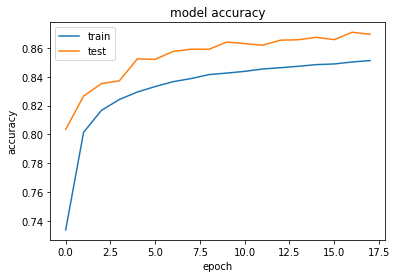

In [19]:
# plot training history
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

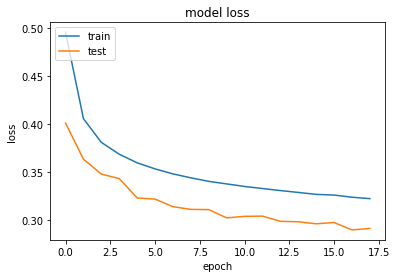

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Visualise Word Embeddings

In [21]:
## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from sklearn.manifold import TSNE

tk = keras.preprocessing.text.Tokenizer(char_level=True) 
word_list = []
for word, i in tk.word_index.items():
    word_list.append(word)
    
## Get weights
glove_embds = model.layers[0].get_weights()[0]
## Plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)
## Visualize words in two dimensions 
glove_tsne_embds = TSNE(n_components=2).fit_transform(glove_embds)
plot_words(glove_tsne_embds, 0, 2000, 1)

In [37]:
# evaluate the model
before_train_evaluation = datetime.datetime.now()
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
after_train_evaluation = datetime.datetime.now()
delta_train_evaluation = after_train_evaluation - before_train_evaluation
print("Model evaluation time on training data", delta_train_evaluation)

before_test_evaluation = datetime.datetime.now()
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
after_test_evaluation = datetime.datetime.now()
delta_test_evaluation = after_test_evaluation - before_test_evaluation
print("Model evaluation time on testing data", delta_test_evaluation)

print('Training Loss: %.3f, Testing loss: %.3f' % (train_loss, test_loss) )
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Model evaluation time on training data 0:02:57.245858
Model evaluation time on testing data 0:00:49.413907
Training Loss: 0.307, Testing loss: 0.308
Train: 0.860, Test: 0.860


In [23]:
# Saving the model and loading the saved model
model.save('../diagram/full_CNN+LSTM_PCA.h5')
# model.save('../saved_models/full_model_CNN_LSTM_without_pca.h5')
# keras.models.load_model('../saved_models/full_model_CNN_LSTM_without_pca.h5')

In [56]:
# def predict(text_x):
# 	x = np.zeros((1, maxlen), dtype=np.int)
# 	offset = max(maxlen - len(text_x), 0)
# 	for t, char in enumerate(text_x):
# 	    if t >= maxlen:
# 	        break
# 	    x[0, t + offset] = char_indices[char]
#     pred = model.predict(x)
# 	return pred[0][0]


# Like predict, but you pass in an array of URLs, and it is all
# vectorized in one step, making it more efficient
def predicts(text_X):
    X = np.zeros((len(text_X), maxlen), dtype=np.int)
    for i in range(len(text_X)):
        offset = max(maxlen - len(text_X[i]), 0)
        for t, char in enumerate(text_X[i]):
            if t >= maxlen:
                break
            X[i, t + offset] = word_index[char]
    preds = [pred[0] for pred in model.predict(X)]
    return preds

In [25]:
# Model Evaluation
# define a threshold value so that values below threshold will be classified as false_positive
threshold = 0.5

def evaluate_model(positives, negatives_train, negatives_dev, negatives_test, threshold):
    false_negatives = 0.0
    preds = predicts(positives)
    for pred in preds:
        if pred <= threshold:
            false_negatives += 1
    print(false_negatives / len(positives), "false negatives for positives set.")

    false_positives_train = 0.0
    preds = predicts(negatives_train)
    for pred in preds:
        if pred > threshold:
            false_positives_train += 1

    false_positives_dev = 0.0
    preds = predicts(negatives_dev)
    for pred in preds:
        if pred > threshold:
            false_positives_dev += 1

    false_positives_test = 0.0
    preds = predicts(negatives_test)
    for pred in preds:
        if pred > threshold:
            false_positives_test += 1

    print(false_positives_train / len(negatives_train), "false positive rate for negative train.")
    print(false_positives_dev / len(negatives_dev), "false positive rate for negative dev.")
    print(false_positives_test / len(negatives_test), "false positive rate for negative test.")

evaluate_model(positives, negatives_train, negatives_dev, negatives_test, threshold)

0.11871017410396345 false negatives for positives set.
0.14305990573143473 false positive rate for negative train.
0.1431457371145152 false positive rate for negative dev.
0.14435086692719762 false positive rate for negative test.


In [45]:
# Getting predictions on negative_dev set to find a suitable threshold value.

# defining the false positive rate which we can change.
fp_rate = 0.01

print("Getting threshold for fp_rate", fp_rate)
preds = predicts(negatives_dev)
preds.sort()
fp_index = math.ceil((len(negatives_dev) * (1 - fp_rate/2)))
threshold = preds[fp_index]

print("Using threshold", threshold) 

evaluate_model(positives, negatives_train, negatives_dev, negatives_test, threshold)

Getting threshold for fp_rate 0.01
Using threshold 0.97505456
0.4410955633733867 false negatives for positives set.
0.004763061629837838 false positive rate for negative train.
0.004987704889483326 false positive rate for negative dev.
0.004890179933543708 false positive rate for negative test.


In [57]:
##  Adapted from https://www.geeksforgeeks.org/bloom-filters-introduction-and-python-implementation/ 

import math 
import mmh3 
from bitarray import bitarray 

class BloomFilter(object): 

	''' 
	Class for Bloom filter, using murmur3 hash function 
	'''

	def __init__(self, items_count,fp_prob): 
		''' 
		items_count : int 
			Number of items expected to be stored in bloom filter 
		fp_prob : float 
			False Positive probability in decimal 
		'''
		# False posible probability in decimal 
		self.fp_prob = fp_prob 

		# Size of bit array to use 
		self.size = self.get_size(items_count,fp_prob) 

		# number of hash functions to use 
		self.hash_count = self.get_hash_count(self.size,items_count) 

		# Bit array of given size 
		self.bit_array = bitarray(self.size) 

		# initialize all bits as 0 
		self.bit_array.setall(0) 

	def add(self, item): 
		''' 
		Add an item in the filter 
		'''
		digests = [] 
		for i in range(self.hash_count): 

			# create digest for given item. 
			# i work as seed to mmh3.hash() function 
			# With different seed, digest created is different 
			digest = mmh3.hash(item,i) % self.size 
			digests.append(digest) 

			# set the bit True in bit_array 
			self.bit_array[digest] = True

	def check(self, item): 
		''' 
		Check for existence of an item in filter 
		'''
		for i in range(self.hash_count): 
			digest = mmh3.hash(item,i) % self.size 
			if self.bit_array[digest] == False: 

				# if any of bit is False then,its not present 
				# in filter 
				# else there is probability that it exist 
				return False
		return True

	@classmethod
	def get_size(self,n,p): 
		''' 
		Return the size of bit array(m) to used using 
		following formula 
		m = -(n * lg(p)) / (lg(2)^2) 
		n : int 
			number of items expected to be stored in filter 
		p : float 
			False Positive probability in decimal 
		'''
		m = -(n * math.log(p))/(math.log(2)**2) 
		return int(m)
    
	@classmethod
	def get_hash_count(self, m, n): 
		''' 
		Return the hash function(k) to be used using 
		following formula 
		k = (m/n) * lg(2) 

		m : int 
			size of bit array 
		n : int 
			number of items expected to be stored in filter 
		'''
		k = (m/n) * math.log(2) 
		return int(k) 


In [58]:
# Defining the threshold value
fp_rate = 0.01
print("Getting threshold for fp_rate", fp_rate)
preds = predicts(negatives_dev)
preds.sort()
fp_index = math.ceil((len(negatives_dev) * (1 - fp_rate/2)))
threshold = preds[fp_index]
print("The threhold value to use is:", threshold)

Getting threshold for fp_rate 0.01
The threhold value to use is: 0.977607


In [59]:
def create_bloom_filter(data):
    print("Creating bloom filter")
    false_negatives = []
    # calling the predicts function 
    preds = predicts(data)
    for i in range(len(data)):
        if preds[i] <= threshold:
            false_negatives.append(data[i])
    print("Number of false negatives at bloom time", len(false_negatives))
    bloom_filter = BloomFilter(len(false_negatives), fp_rate / 2)
    for fn in false_negatives:
        bloom_filter.add(fn)
    print("Created bloom filter")
    return bloom_filter

bloom_filter = create_bloom_filter(positives)

Creating bloom filter
Number of false negatives at bloom time 588216
Created bloom filter


In [60]:
# Function to predict the output from the machine learning model
def predict(text_x):
    x = np.zeros((1, maxlen), dtype=np.int)
    offset = max(maxlen - len(text_x), 0)
    for t, char in enumerate(text_x):
        if t >= maxlen:
            break
        x[0, t + offset] = word_index[char]
    pred = model.predict(x)
    return pred[0][0]


def check_item(item):
    if predict(item) > threshold:
        return True
    return bloom_filter.check(item)

In [61]:
print("Bloom filter bits needed", bloom_filter.size)
# print("Bloom fiter size in bytes", bloom_filter.byte_size)
print("Hash functions needed", bloom_filter.hash_count)
    
false_positives = 0.0
for neg in negatives_test:
    if check_item(neg):
        false_positives += 1
print("Test false positive rate: ", str(false_positives / len(negatives_test)))

Bloom filter bits needed 6486701
Hash functions needed 7


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f85c4afb0d0>
Traceback (most recent call last):
  File "/research_data/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 538, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/research_data/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: 